In [51]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [52]:
torch.cuda.is_available()

True

In [53]:
class ReplayMemory():
    def __init__(self, capacity, num_actions, batch_size, input_dims, eps=0, eps_min=0, eps_decay=0):
        self.capacity = capacity
        self.batch_size = batch_size
        self.state_memory  = np.zeros((capacity, input_dims), dtype=np.float32)
        self.action_memory = np.zeros((capacity, num_actions), dtype=np.float32)
        self.reward_memory = np.zeros(capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((capacity, input_dims), dtype=np.float32)
        self.terminal_memory = np.zeros(capacity, dtype=np.bool)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.experience_ctr = 0
        
    def store(self, state, action, reward, next_state, terminal):
        index = self.experience_ctr % self.capacity
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = terminal
        self.experience_ctr += 1
        
    def can_provide_batch(self):
        return self.experience_ctr >= self.batch_size
    
    def give_batch(self):
        length = min(self.experience_ctr, self.capacity)
        batch = np.random.choice(length, self.batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]
        return (states, actions, rewards, next_states, terminals)
    
    def get_epsilon(self):
        #print(self.experience_ctr)
        rate = self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.experience_ctr / self.eps_decay)
        return rate

In [54]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [55]:
class Actor(nn.Module):
    def __init__(self, input_dims, num_actions, lr):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dims, out_features=512)  #
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        #self.loss = nn.MSELoss()
        
    def forward(self, t):
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.fc3(t)
        #t = F.relu(t)
        t = torch.tanh(t)
        return t

In [56]:
class Critic(nn.Module):
    def __init__(self, input_dims, num_actions, lr):
        super().__init__()

        self.V_fc1 = nn.Linear(in_features=input_dims, out_features=512)  #
        self.V_fc2 = nn.Linear(in_features=512, out_features=256)
        #self.V_fc3 = nn.Linear(in_features=256, out_features=128)
        self.A_fc1 = nn.Linear(in_features=num_actions, out_features=128)
        self.A_fc2 = nn.Linear(in_features=128, out_features=256)
        self.AV_fc = nn.Linear(in_features=256, out_features=1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()


        
    def forward(self, t, a):
        t = self.V_fc1(t)
        t = F.relu(t)
        state_value = self.V_fc2(t)
        #t = F.relu(t)
        #state_value = self.V_fc3(t)

        #print(a, type(a))

        action_value = self.A_fc1(a)
        action_value = self.A_fc2(action_value)
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.AV_fc(state_action_value)

        return state_action_value

In [57]:
def get_tensors(batch, device):
    states = torch.tensor(batch[0]).to(device)
    actions = torch.tensor(batch[1]).to(device)
    rewards = torch.tensor(batch[2]).to(device)
    next_states = torch.tensor(batch[3]).to(device)
    dones = torch.tensor(batch[4]).to(device)
    return states, actions, rewards, next_states, dones

In [60]:
class Agent():
    def __init__(self, input_dims, num_actions, lr_actor, lr_critic, gamma, tau, batch_size, capacity, device):
        self.num_actions = num_actions
        self.input_dims = input_dims
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.tau = tau
        #self.device = device
        self.memory = ReplayMemory(capacity, num_actions, batch_size, input_dims)
        self.critic = Critic(input_dims, num_actions, lr_critic).to(device)
        self.critic_target = Critic(input_dims, num_actions, lr_critic).to(device)
        self.actor = Actor(input_dims, num_actions, lr_actor).to(device)
        self.actor_target = Actor(input_dims, num_actions, lr_actor).to(device)
        self.noise = OUActionNoise(mu=np.zeros(num_actions))#.to(device)
        

    def select_action(self, obs, device):
        self.actor.eval()
        obs = torch.tensor([obs], dtype=torch.float32).to(device)
        mu = self.actor.forward(obs)
        mu = mu + torch.tensor(self.noise(), dtype=torch.float32).to(device)
        mu = mu.cpu().detach().numpy()[0]#reshape()
        self.actor.train()
        return mu

    def get_tensors(self, batch, device):
        states = torch.tensor(batch[0]).to(device)
        actions = torch.tensor(batch[1], dtype=torch.float32).to(device)
        rewards = torch.tensor(batch[2]).to(device)
        next_states = torch.tensor(batch[3]).to(device)
        dones = torch.tensor(batch[4]).to(device)
        #print(type(actions))
        return states, actions, rewards, next_states, dones


    def learn(self, device):
        if self.memory.can_provide_batch():
            batch = self.memory.give_batch()
            states, actions, rewards, next_states, dones = self.get_tensors(batch, device)
            #print(type(actions))
            next_actions = self.actor_target.forward(next_states)
            next_q_value = self.critic_target.forward(next_states, next_actions)
            current_q_value = self.critic.forward(states, actions)

            # self.critic.eval()
            # self.critic_target.eval()
            # self.actor_target.eval()

            next_q_value[dones] = 0
            #next_q_value = next_q_value.reshape(-1,1)
            #rewards = rewards.reshape(-1,1)
            #dones = dones.reshape(-1,1)
            #print(next_q_value.shape, dones.shape)
            #next_q_value = next_q_value * dones
            #print(next_q_value.shape)
            next_q_value = next_q_value.view(-1)
            #current_q_value.reshape(-1,1)
            calc_q_value = rewards + self.gamma * next_q_value # * dones
            calc_q_value = calc_q_value.reshape(-1,1)#.detach()
            #print(next_q_value.shape, rewards.shape, calc_q_value.shape)

            #self.critic.train()
            self.critic.optimizer.zero_grad()
            critic_loss = F.mse_loss(calc_q_value, current_q_value) #self.critic.loss(calc_q_value, current_q_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.critic.eval()
            self.actor.optimizer.zero_grad()
            #self.critic.eval()
            #self.actor.eval()
            temp_actions = self.actor.forward(states)
            #self.actor.train()
            actor_loss = -self.critic.forward(states, temp_actions)
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()
            self.critic.train()

            self.update_target_networks(self.tau)

    def update_target_networks(self, tau):
        actor_params = dict(self.actor.named_parameters())
        actor_target_params = dict(self.actor_target.named_parameters())
        critic_params = dict(self.critic.named_parameters())
        critic_target_params = dict(self.critic_target.named_parameters())

        for name in actor_params:
            actor_params[name] = tau*actor_params[name].clone() + (1-tau)*actor_target_params[name].clone()

        for name in critic_params:
            critic_params[name] = tau*critic_params[name].clone() + (1-tau)*critic_target_params[name].clone()

        self.actor_target.load_state_dict(actor_params)
        self.critic_target.load_state_dict(critic_params)





In [61]:
env = gym.make('BipedalWalker-v3')
env.reset()
#print(env.step([0.1])[0])
env.observation_space.shape

(24,)

In [63]:
capacity = 1000000
batch_size = 128
tau = 0.001
num_actions = env.action_space.shape[0]
input_dims = env.observation_space.shape[0]
episodes = 500
lr_actor = 0.001
lr_critic = 0.0001
gamma = 0.99
#reward_track = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Number or actions : ', num_actions)
print('Action space : ', env.action_space)
print('Observation space : ', env.observation_space)


Number or actions :  4
Action space :  Box(-1.0, 1.0, (4,), float32)
Observation space :  Box(-inf, inf, (24,), float32)


In [64]:
agent = Agent(input_dims, num_actions, lr_actor, lr_critic, gamma, tau, batch_size, capacity, device)

/tmp/ipykernel_4993/1151440733.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(capacity, dtype=np.bool)


In [ ]:
reward_track = []
for episode in range(episodes):
    print('Episode : ', episode, end='\t')
    score = 0
    terminal = False
    state = env.reset()
    while not terminal:
        # rate = memory.get_epsilon()
        # #print(rate)
        # eps_track.append(rate)
        action = agent.select_action(state, device)
        #action = action.cpu().detach().numpy().reshape(-1,)
        #print(action)
        next_state, reward, terminal, emp = env.step(action)
        if terminal:
            done = 0
        else:
            done = 1
        #state = state.reshape(-1,1)
        #next_state = next_state.reshape(-1,)
        #action = torch.tensor(action, dtype=torch.float32)
        #print(state.shape, next_state.shape)
        agent.memory.store(state, action, reward, next_state, terminal)
        state = next_state
        score += reward

        agent.learn(device)
        state = next_state
    print('score : ', score)
    reward_track.append(score)
    # print('score : ', score.item())
    # reward_track.append(score.item())



In [81]:
env.reward_range[0]

-inf

Text(0, 0.5, 'Rewards')

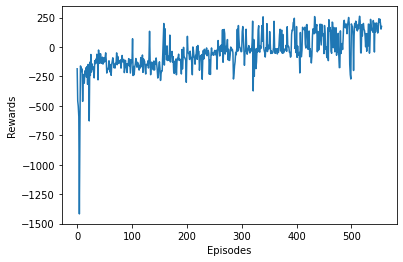

In [310]:
plt.plot(reward_track)        #LunarLanderContinuous-v2
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Rewards')

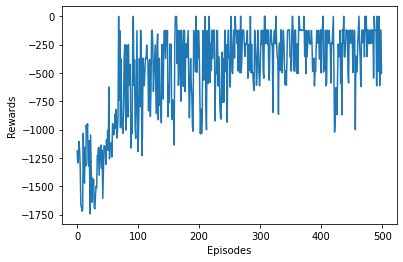

In [15]:
plt.plot(reward_track)         #Pendulum-v0
plt.xlabel('Episodes')
plt.ylabel('Rewards')